## Models

In [1]:
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor, LGBMClassifier, plot_tree, create_tree_digraph, plot_metric
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from scipy import stats
import sys  
sys.path.insert(0, '/home/brunovieira/backup/Tamires_Experiments/Scripts')
import thinning_processing as tp
import thinning_modelling as tm
import thinning_explicability as te

pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)

/home/brunovieira/.conda/envs/tamires/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
paths = {
    'data_economo': "/home/brunovieira/backup/Tamires_Experiments/Data/Economo/data_894_economo.parquet",
    'dict_economo': "/home/brunovieira/backup/Tamires_Experiments/Data/Economo/dict_economo.csv",
    'data_dkt': "/home/brunovieira/backup/Tamires_Experiments/Data/DKT/data_894_dkt.parquet", 
    'dict_dkt': "/home/brunovieira/backup/Tamires_Experiments/Data/DKT/dict_dkt.csv",
    'data_bb': "/home/brunovieira/backup/Tamires_Experiments/Data/cytoarchitecture.xlsx"}

In [3]:
df = tp.read_database('Economo', paths)
taxa_anual = tp.reg_polynomial(df) 
df1 = tp.build_main_dataframe(df, taxa_anual)
df1.columns

Index(['Age', 'Hemisphere', 'atlas', 'area', 'curv', 'Curvature', 'thickness',
       'Gender', 'handedness', 've_1', 've_2', 've_3', 've_4', 've_5', 've_6',
       'bigbrain_layer_1', 'bigbrain_layer_2', 'bigbrain_layer_3',
       'bigbrain_layer_4', 'bigbrain_layer_5', 'bigbrain_layer_6',
       'bigbrain_layer_1_r', 'bigbrain_layer_2_r', 'bigbrain_layer_3_r',
       'bigbrain_layer_4_r', 'bigbrain_layer_5_r', 'bigbrain_layer_6_r',
       'bblayer1_age', 'bblayer2_age', 'bblayer3_age', 'bblayer4_age',
       'bblayer5_age', 'bblayer6_age', 've1_age', 've2_age', 've3_age',
       've4_age', 've5_age', 've6_age', 'Lobe', 'anual_rate',
       'Thickness at 10y.o.', 'Thickness at 80y.o.', 'thickness_mean',
       'Layer I thickness', 'Layer II thickness', 'Layer III thickness',
       'Layer IV thickness', 'Layer V thickness', 'Layer VI thickness',
       'sum_thickness_layers', 'h_structure', 'structure_name'],
      dtype='object')

In [4]:
features_sets = [['Thickness at 10y.o.', 
                  'Curvature', 
                  'Hemisphere', 'Gender',
                  'Lobe', 
                  'Layer I thickness','Layer II thickness','Layer III thickness',
                  'Layer IV thickness','Layer V thickness','Layer VI thickness'],
                 
                 ['Age'],
    
                 ['Age','Thickness at 10y.o.', 
                  'Curvature', 
                  'Hemisphere', 'Gender',
                  'Lobe', 
                  'Layer I thickness','Layer II thickness','Layer III thickness',
                  'Layer IV thickness','Layer V thickness','Layer VI thickness']]

# criando estrutura de armazenamento dos dados dos modelos
cortical_structures = np.unique(np.sort([int(x[1:]) for x in df1.h_structure.unique()]))
shape = (len(features_sets), len(cortical_structures))
X_train = np.empty(shape, dtype=object)
X_test = np.empty(shape, dtype=object) 
y_train = np.empty(shape, dtype=object) 
y_test = np.empty(shape, dtype=np.ndarray) 
lgbm = np.empty(shape, dtype=object)
y_pred = np.empty(shape, dtype=object) 
r2 = np.empty(shape, dtype=object)
models_evaluation = np.empty((len(features_sets),8))

# criando modelos
for i, features in enumerate(features_sets):      
    for j, structure in enumerate(cortical_structures):
        X_train[i,j], X_test[i,j], y_train[i,j], y_test[i,j] = tm.split_train_test(df1, features, structure)
        lgbm[i,j] = tm.model_train(X_train[i,j], y_train[i,j])
        y_pred[i,j], r2[i,j] = tm.model_test(lgbm[i,j], X_test[i,j], y_test[i,j])
    models_evaluation[i] = tm.model_test_all(y_test[i], y_pred[i], r2[i]) 


In [5]:
df_eval_1 = tm.evaluation_structures(df1, cortical_structures, r2)
df_eval_1

structure  r2_spatial  r2_temporal  r2_complete  \
0         2.0   -0.010000    -0.010000    -0.010000   
1         3.0    0.726489     0.581724     0.861486   
2         4.0    0.747100     0.862423     0.854874   
3         5.0    0.757286     0.786441     0.695004   
4         6.0    0.785039     0.841967     0.932745   
5         7.0    0.506694     0.810530     0.837353   
6         8.0    0.578398     0.857906     0.897225   
7         9.0    0.568026     0.665652     0.749809   
8        10.0    0.830221     0.912671     0.942132   
9        11.0    0.657807     0.874948     0.851133   
10       12.0    0.392996     0.754384     0.941901   
11       13.0   -0.010000     0.756572     0.553079   
12       18.0    0.848402     0.901063     0.923374   
13       19.0    0.661115     0.831051     0.971947   
14       20.0    0.532302     0.815333     0.894027   
15       21.0    0.364153     0.562332     0.751550   
16       22.0    0.738419     0.890687     0.959550   
17       23.0   -0.010000     0.828280     0.654660   
18       24.0   -0.010000    -0.010000    -0.010000   
19       25.0    0.420528     0.707614     0.812553   
20       27.0    0.380956     0.849555     0.727957   
21       28.0   -0.010000    -0.010000    -0.010000   
22       29.0    0.213602     0.323163     0.528791   
23       30.0    0.470780     0.938854     0.938259   
24       31.0   -0.010000    -0.010000     0.797177   
25       32.0   -0.010000    -0.010000    -0.010000   
26       33.0    0.509563     0.875292     0.943885   
27       34.0    0.514894     0.965679     0.984036   
28       35.0    0.748147     0.913937     0.974074   
29       36.0    0.454133     0.857486     0.918778   
30       37.0   -0.010000     0.967667     0.939312   
31       38.0    0.409884     0.694804     0.795866   
32       39.0   -0.010000     0.409329     0.582550   
33       40.0    0.675403     0.947526     0.938089   
34       41.0    0.463736     0.763842     0.883608   
35       42.0    0.802679     0.939645     0.939954   
36       43.0   -0.010000     0.852137     0.807278   
37       44.0   -0.010000    -0.010000    -0.010000   

                                      structure_name  atlas  
0                                   Precentral Gyrus    2.0  
1                             Agranular Frontal Area    3.0  
2                          Intermediate Frontal Area    4.0  
3      Magnocellular Agranular Intermediated Frontal    5.0  
4                              Granular Frontal Area    6.0  
5                       Middle Granular Frontal Area    7.0  
6                   Triangular Granular Frontal Area    8.0  
7                                  Frontalpolar Area    9.0  
8                                       Orbital Area   10.0  
9                                      Straight Area   11.0  
10                                   Prefrontal Area   12.0  
11                             Frontal Piriform Area   13.0  
12                           Precentral Insular Area   18.0  
13                          Postcentral Insular Area   19.0  
14       Precingulate Agranular Anterior Limbic Area   20.0  
15          Cingulate Agranular Anterior Limbic Area   21.0  
16                   Dorsal Posterior Cingulate Area   22.0  
17                  Ventral Posterior Cingulate Area   23.0  
18                 Posterior Limitans Cingulate Area   24.0  
19                     Angranular Retrosplenial Area   25.0  
20                       Peristriate Occipital Area    27.0  
21                       Parastriate Occipital Area    28.0  
22                           Striate Occipital Area    29.0  
23  Postcentral-Postparacentral Giant Pyrimidal Area   30.0  
24           Oral Postcentral Area Simplex-Granulosa   31.0  
25                     Intermediate Postcentral Area   32.0  
26                           Caudal Postcentral Area   33.0  
27                            Superior Parietal Area   34.0  
28                                Supramarginal Area   35.0 

In [6]:
df_eval_2 = tm.evaluation_features(features_sets, models_evaluation)
df_eval_2

r2_all   r2_mean    r2_std    r2_sem  r2_mean_clean  r2_std_clean  \
0  0.309488 -1.120799  6.844545  1.125236       0.583658      0.166657   
1  0.698222 -0.178605  2.501638  0.411267       0.798140      0.149816   
2  0.810770  0.275863  1.898848  0.312169       0.841940      0.123908   

   r2_sem_clean  inexplicable  \
0      0.032684          11.0   
1      0.026908           6.0   
2      0.021904           5.0   

                                        features_set  \
0  [Thickness at 10y.o., Curvature, Hemisphere, G...   
1                                              [Age]   
2  [Age, Thickness at 10y.o., Curvature, Hemisphe...   

                          labels  
0               Spatial Features  
1              Temporal Features  
2  Temporal and Spatial Features

In [7]:
df_summarize = tm.summarize_info(df1, df_eval_1)
df_summarize

atlas_x  Hemisphere  Lobe  Thickness at 10y.o.  Thickness at 80y.o.  \
0      10.0         0.0   1.0                 3.06                 2.44   
1      10.0         1.0   1.0                 3.15                 2.47   
2      11.0         0.0   1.0                 2.80                 2.32   
3      11.0         1.0   1.0                 2.70                 2.44   
4      12.0         0.0   1.0                 2.82                 2.39   
5      12.0         1.0   1.0                 2.94                 2.57   
6      13.0         0.0   1.0                 3.64                 2.78   
7      13.0         1.0   1.0                 3.47                 2.63   
8      18.0         0.0   2.0                 3.48                 2.68   
9      18.0         1.0   2.0                 3.58                 2.72   
10     19.0         0.0   2.0                 3.43                 2.53   
11     19.0         1.0   2.0                 3.58                 2.51   
12      2.0         0.0   1.0                 2.78                 2.16   
13      2.0         1.0   1.0                 2.83                 2.37   
14     20.0         0.0   3.0                 3.17                 2.51   
15     20.0         1.0   3.0                 3.24                 2.57   
16     21.0         0.0   3.0                 3.19                 2.62   
17     21.0         1.0   3.0                 2.81                 2.45   
18     22.0         0.0   3.0                 3.08                 2.39   
19     22.0         1.0   3.0                 3.18                 2.42   
20     23.0         0.0   3.0                 3.60                 2.77   
21     23.0         1.0   3.0                 3.03                 2.81   
22     24.0         0.0   3.0                 2.26                 2.04   
23     24.0         1.0   3.0                 2.30                 2.07   
24     25.0         0.0   3.0                 3.03                 2.52   
25     25.0         1.0   3.0                 2.89                 1.93   
26     27.0         0.0   4.0                 2.29                 1.83   
27     27.0         1.0   4.0                 2.37                 1.91   
28     28.0         0.0   4.0                 1.95                 1.74   
29     28.0         1.0   4.0                 2.06                 1.92   
30     29.0         0.0   4.0                 1.96                 1.55   
31     29.0         1.0   4.0                 1.91                 1.61   
32      3.0         0.0   1.0                 3.07                 2.43   
33      3.0         1.0   1.0                 2.98                 2.41   
34     30.0         0.0   5.0                 2.28                 1.85   
35     30.0         1.0   5.0                 2.25                 1.86   
36     31.0         0.0   5.0                 1.85                 1.52   
37     31.0         1.0   5.0                 1.65                 1.44   
38     32.0         0.0   5.0                 2.46                 2.02   
39     32.0         1.0   5.0                 2.34                 2.04   
40     33.0         0.0   5.0                 2.58                 1.98   
41     33.0         1.0   5.0                 2.51                 1.97   
42     34.0         0.0   5.0                 2.68                 2.13   
43     34.0         1.0   5.0                 2.69                 2.07   
44     35.0         0.0   5.0                 3.05                 2.38   
45     35.0         1.0   5.0                 2.96                 2.29   
46     36.0         0.0   5.0                 2.89                 2.35   
47     36.0         1.0   5.0                 2.93                 2.25   
48     37.0         0.0   5.0                 2.75                 2.22   
49     37.0         1.0   5.0                 2.79                 2.17   
50     38.0         0.0   6.0                 3.27                 2.44   
51     38.0         1.0   6.0                 3.21                 2.49   
52     39.0         0.0   6.0

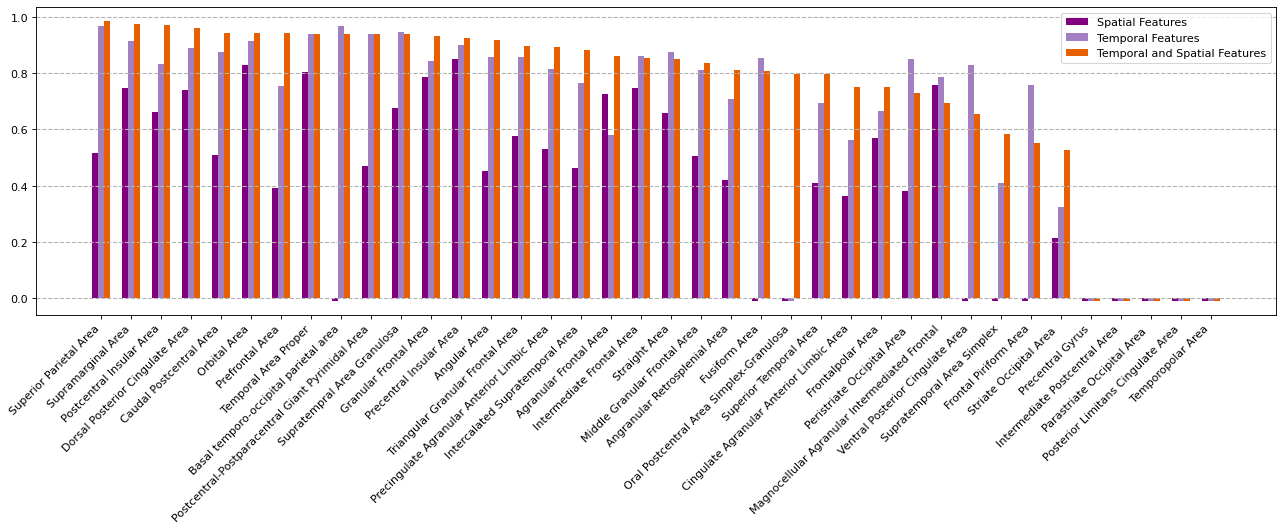

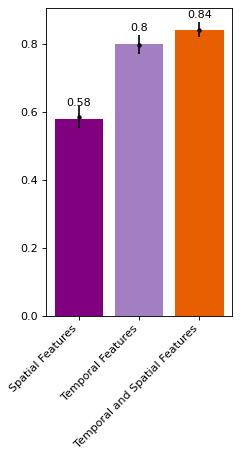

In [8]:
tm.plot_bar_models(df_eval_1, df_eval_2)

## Explicability

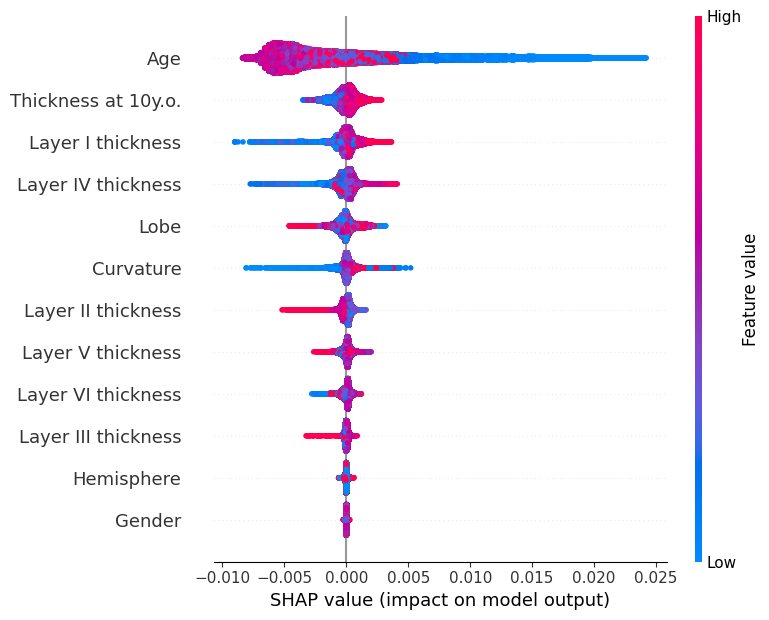

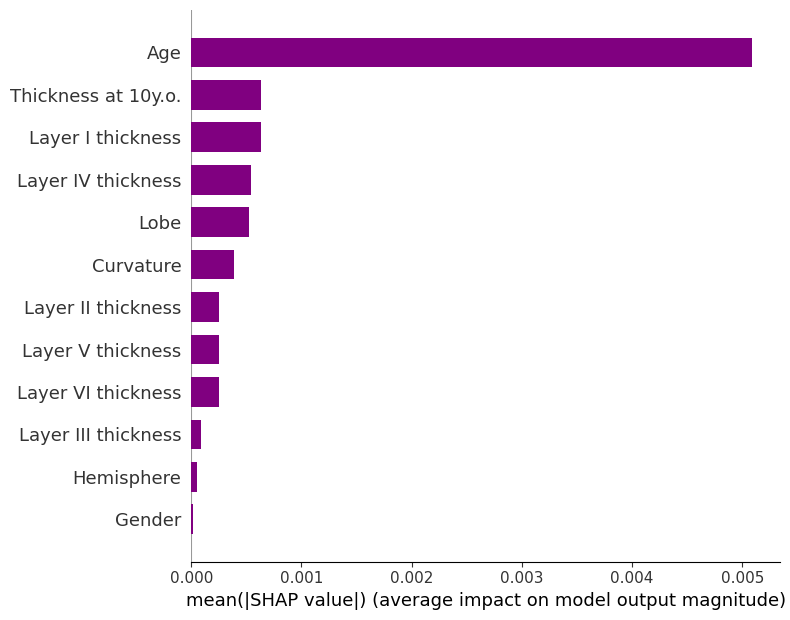

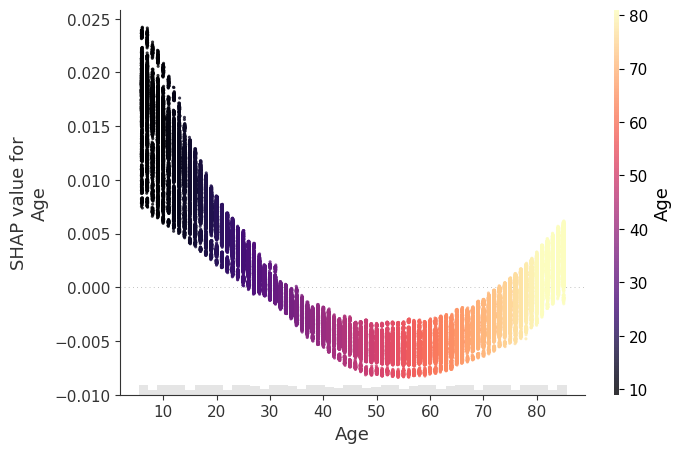

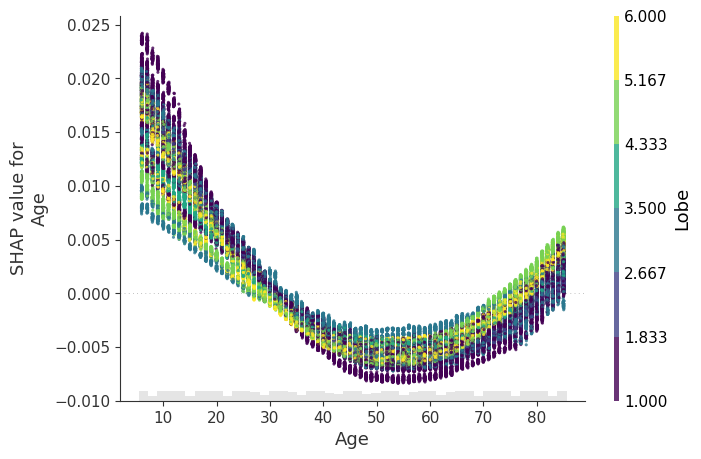

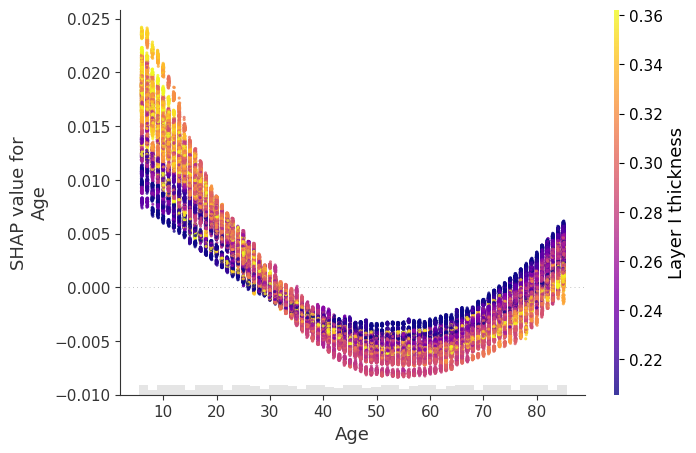

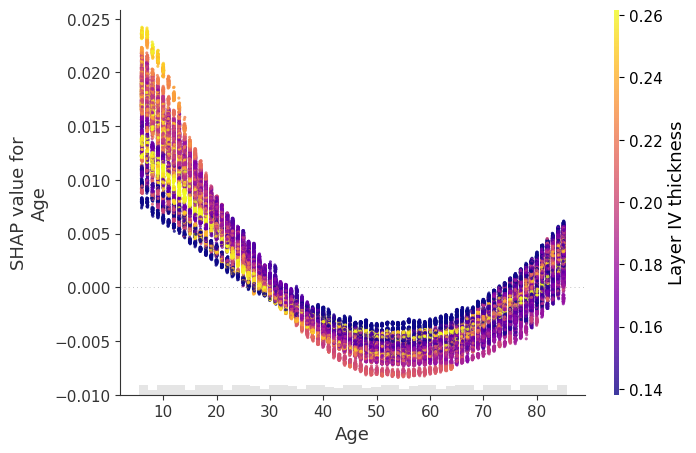

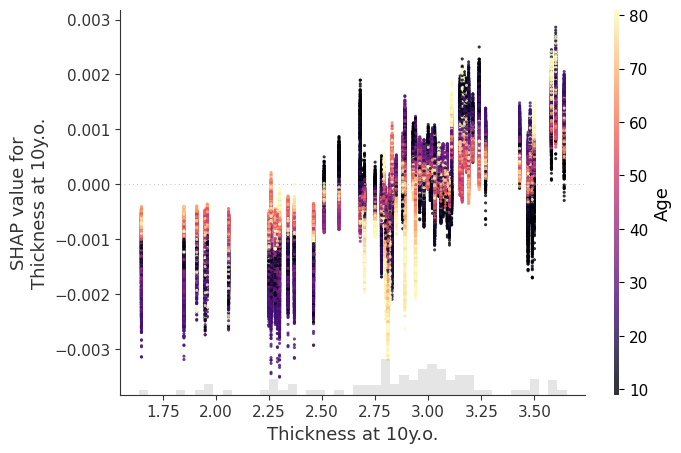

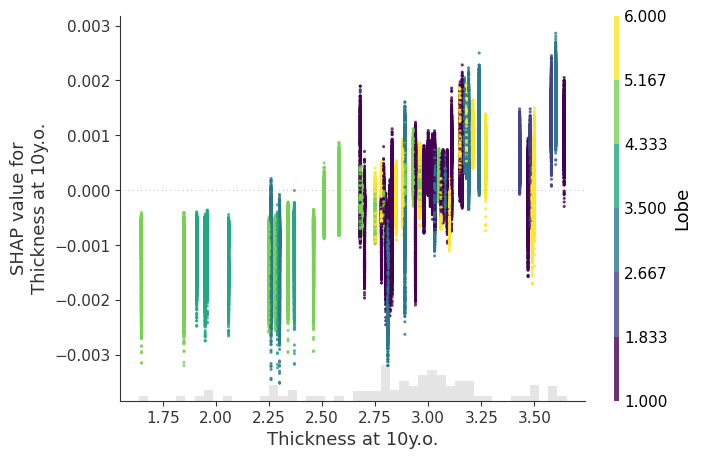

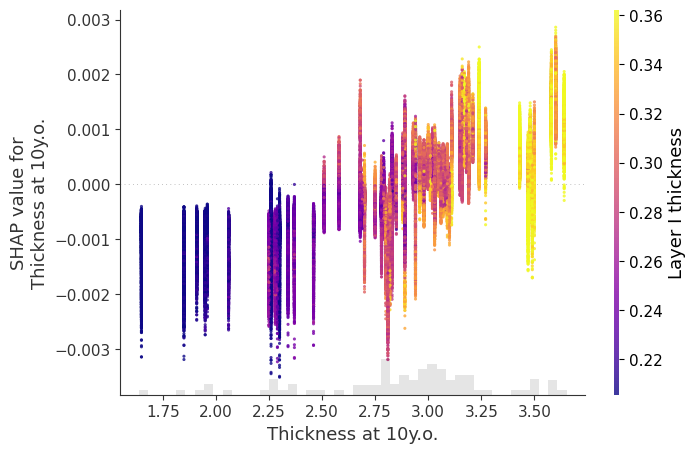

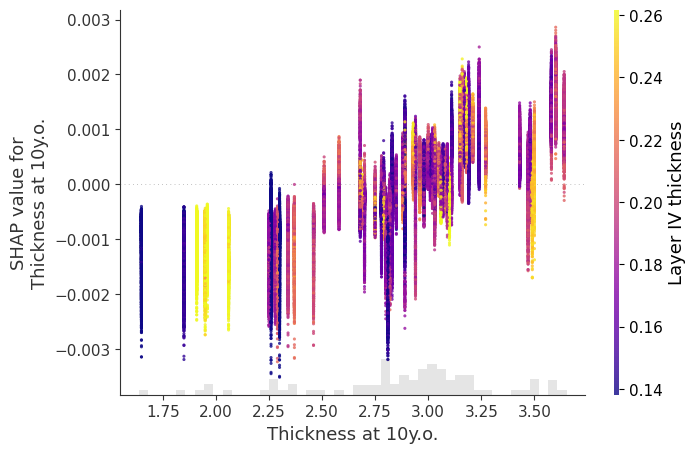

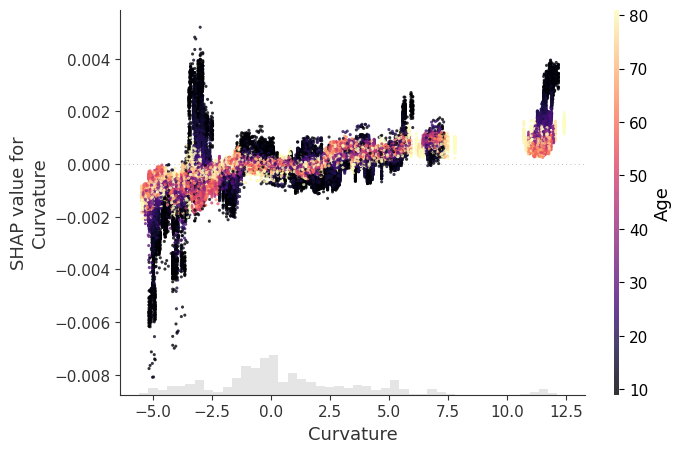

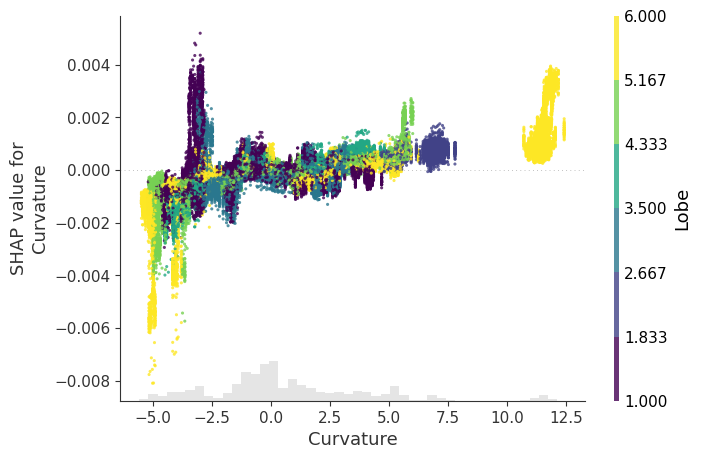

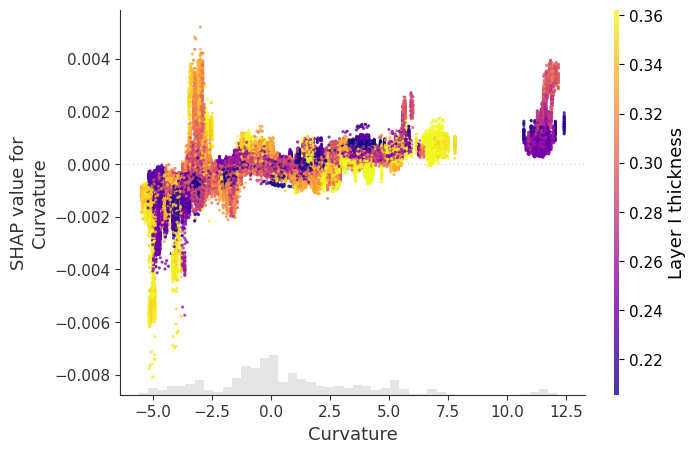

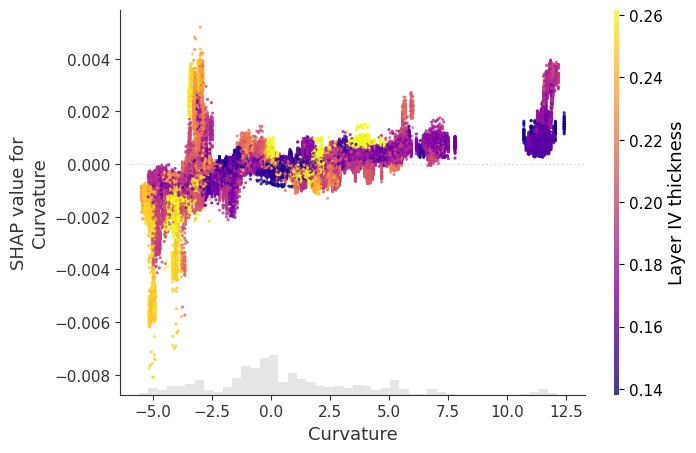

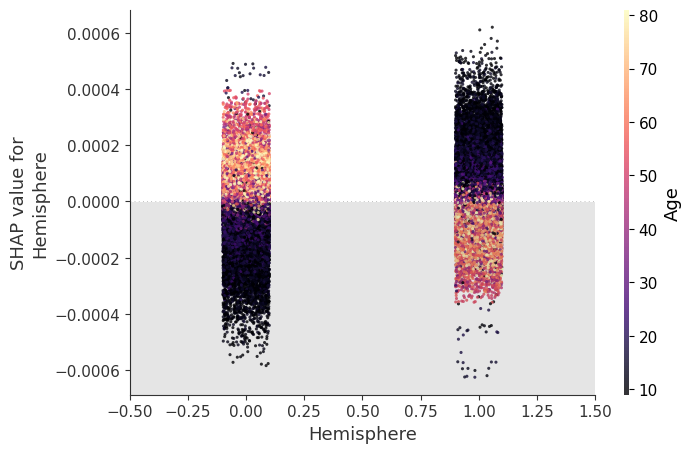

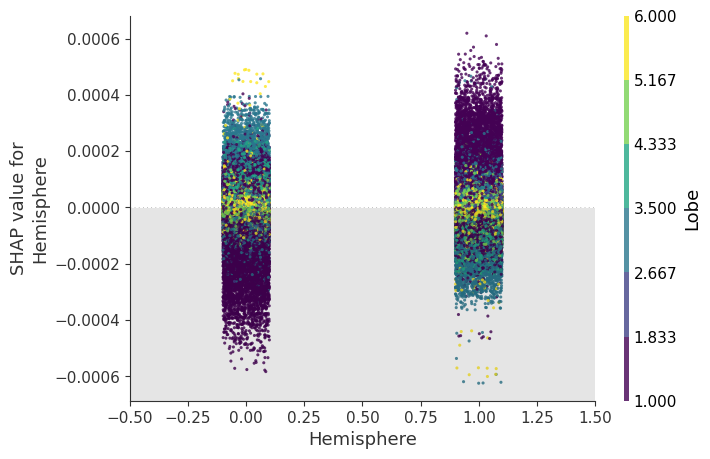

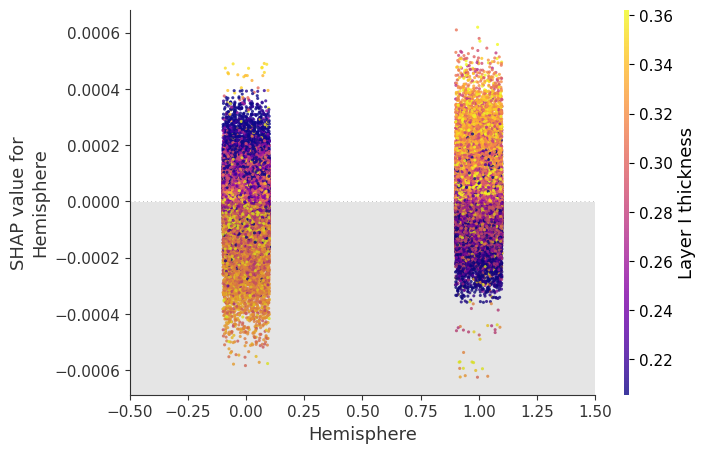

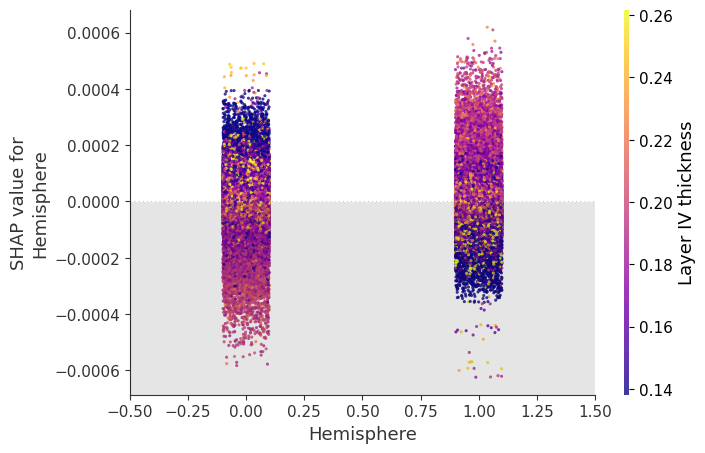

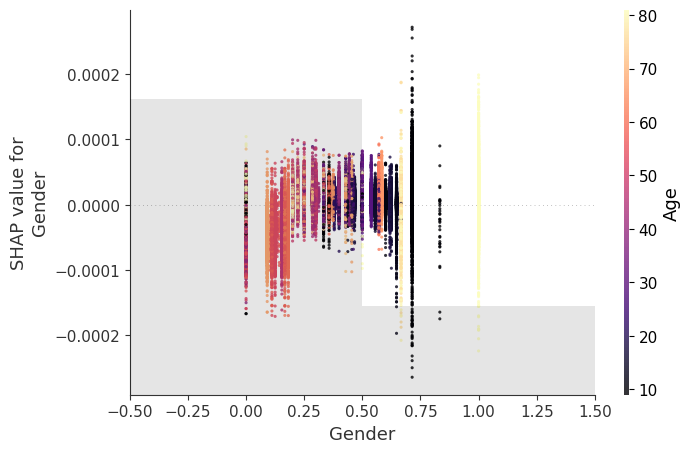

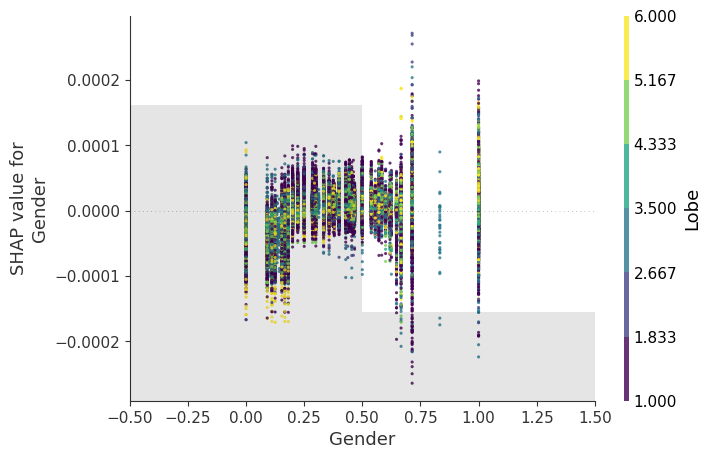

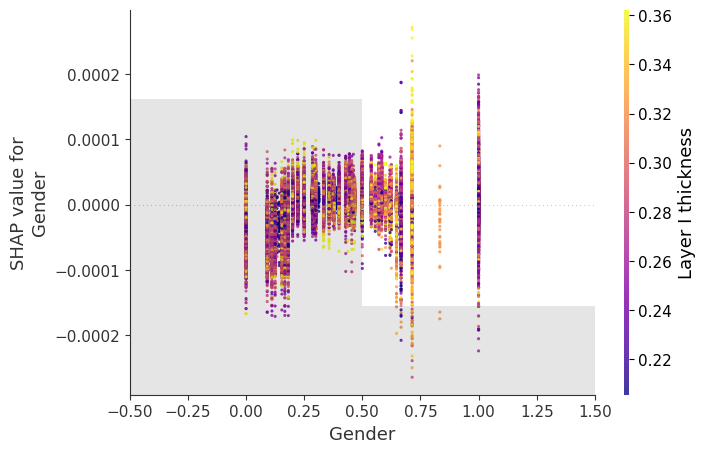

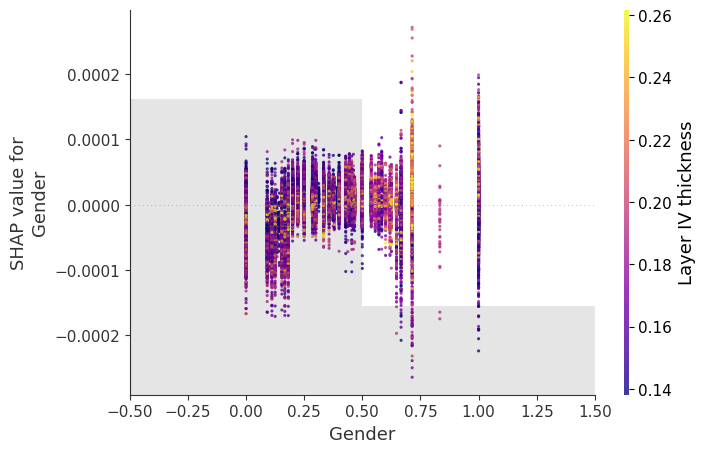

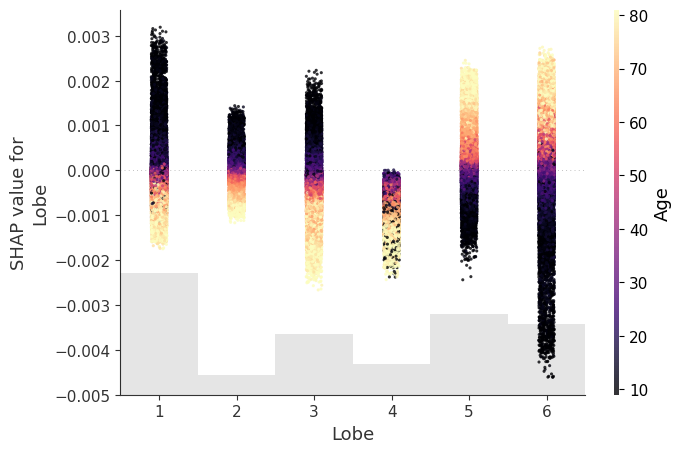

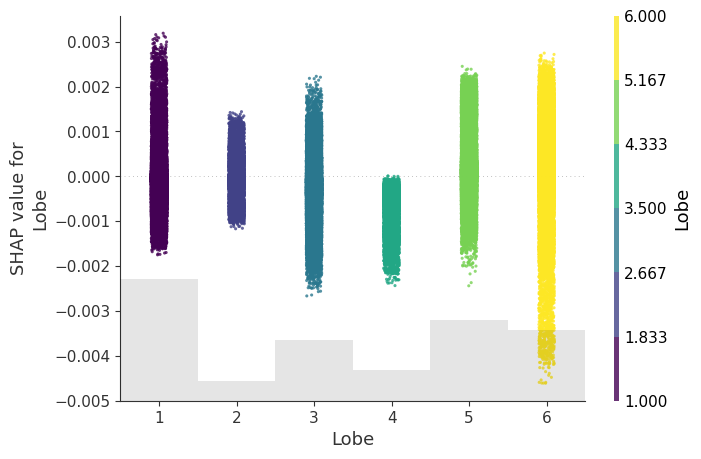

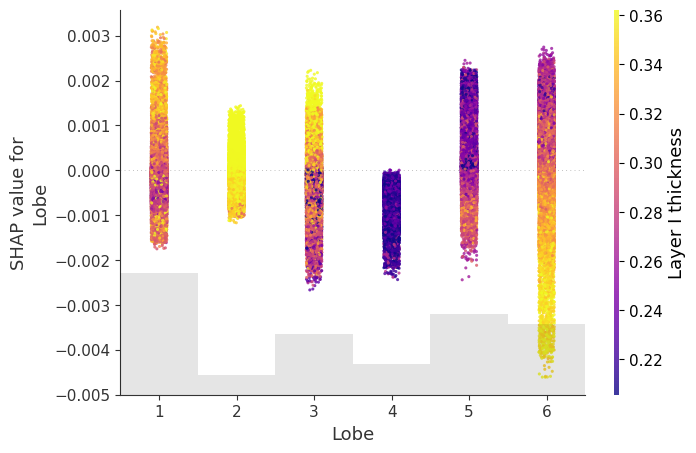

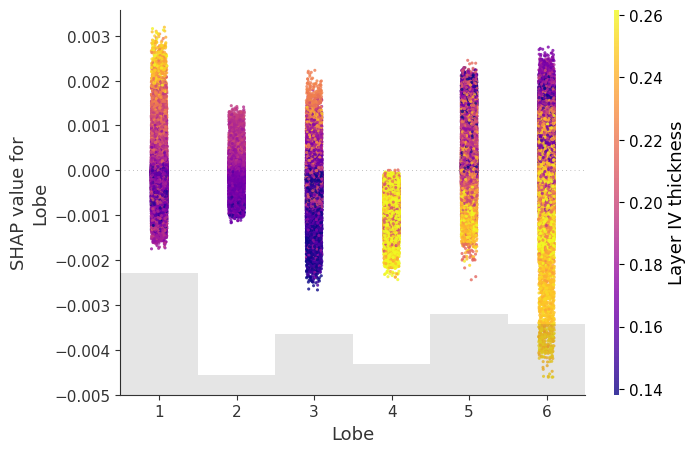

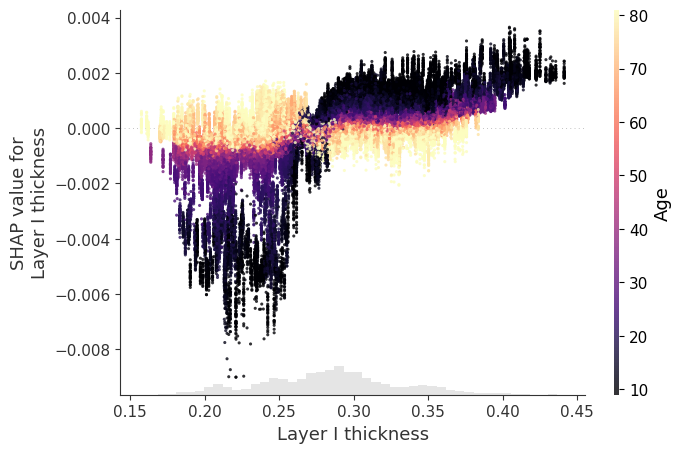

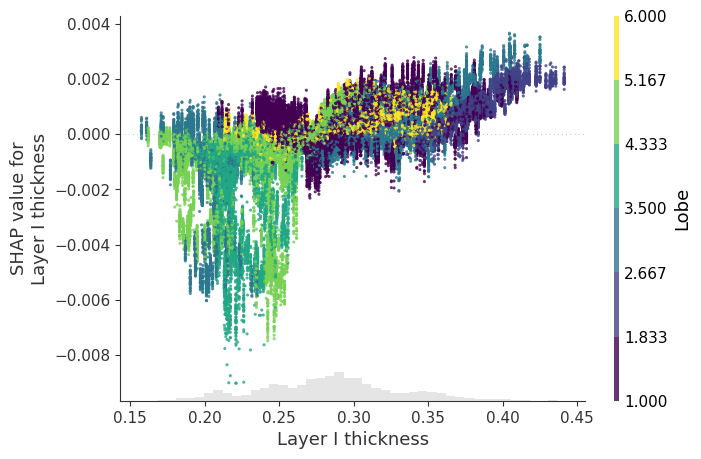

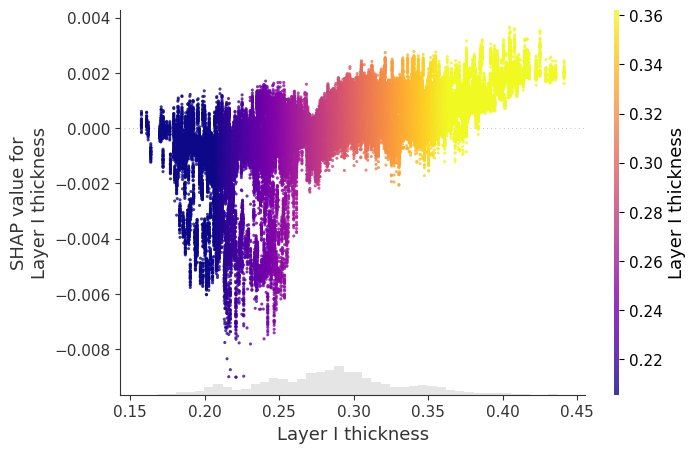

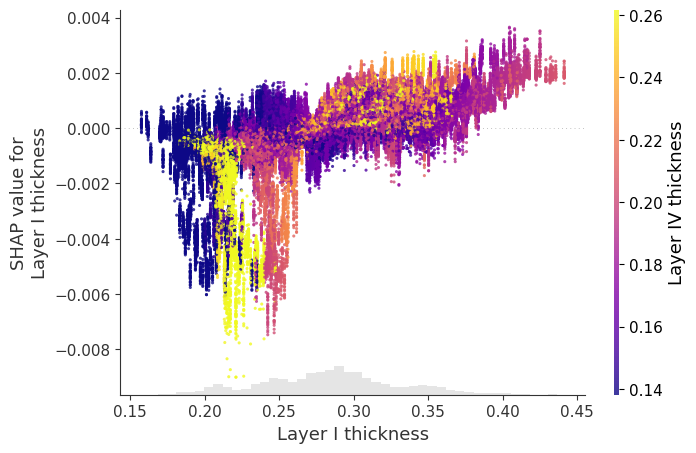

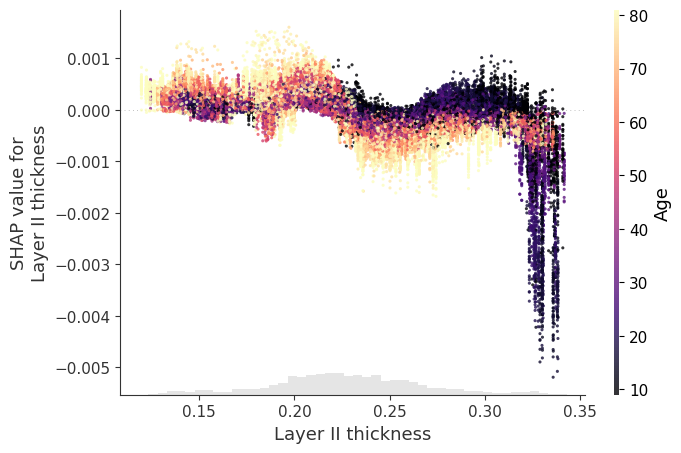

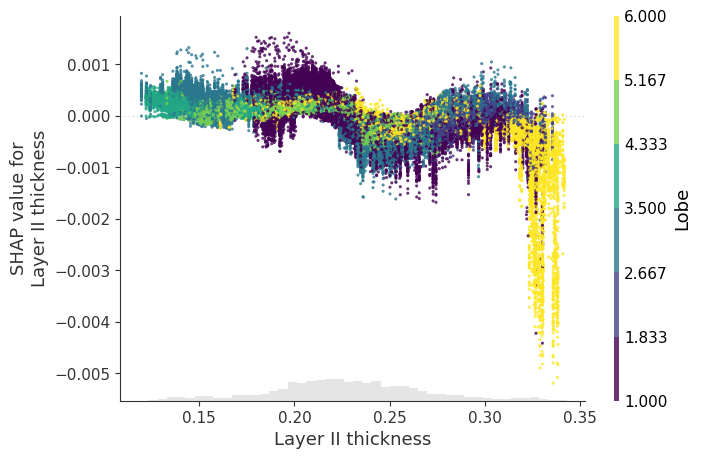

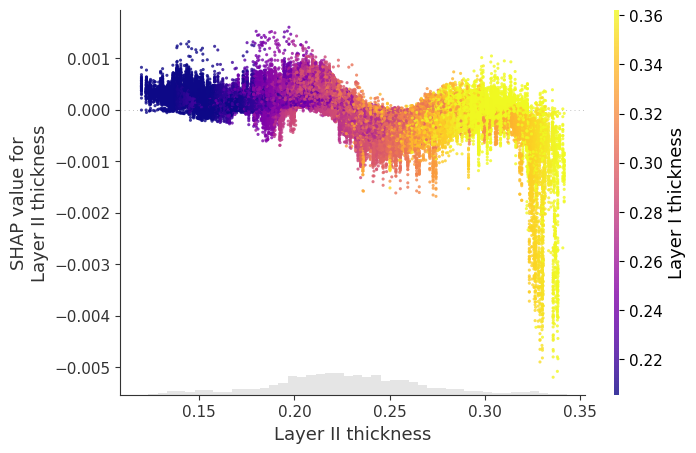

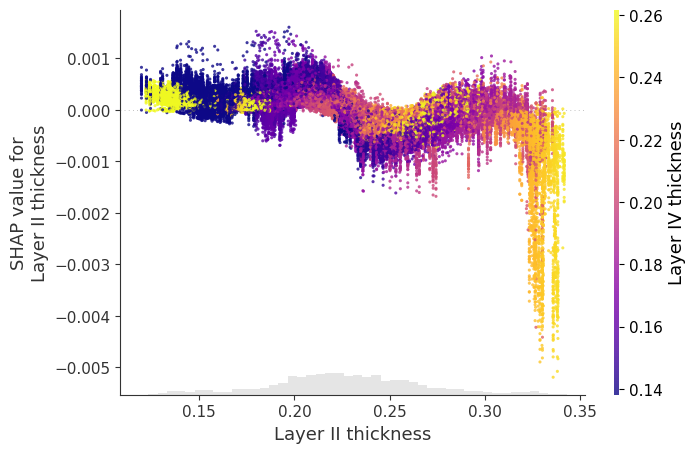

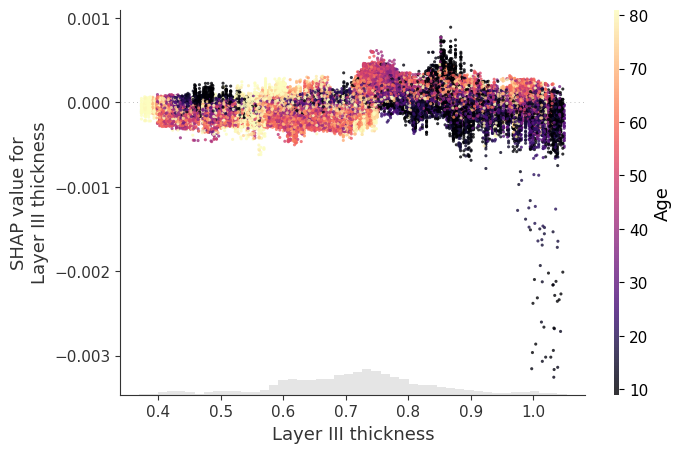

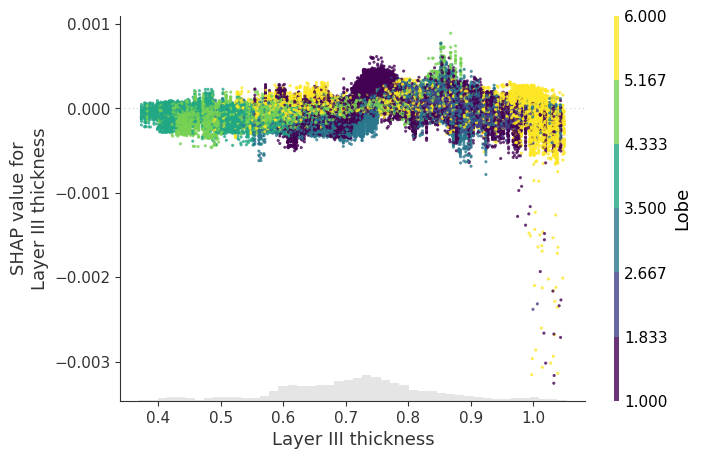

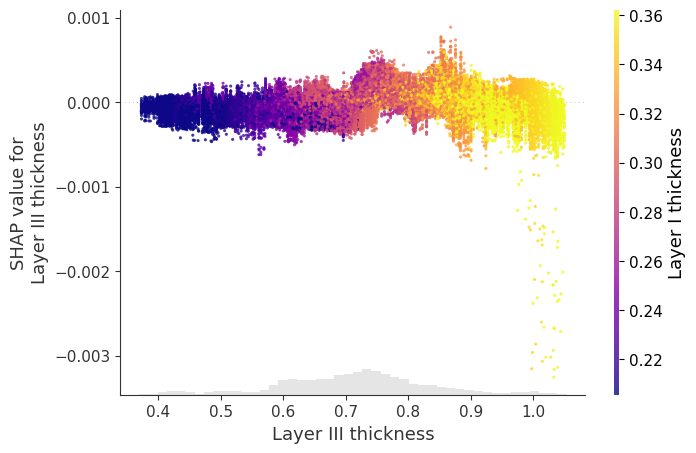

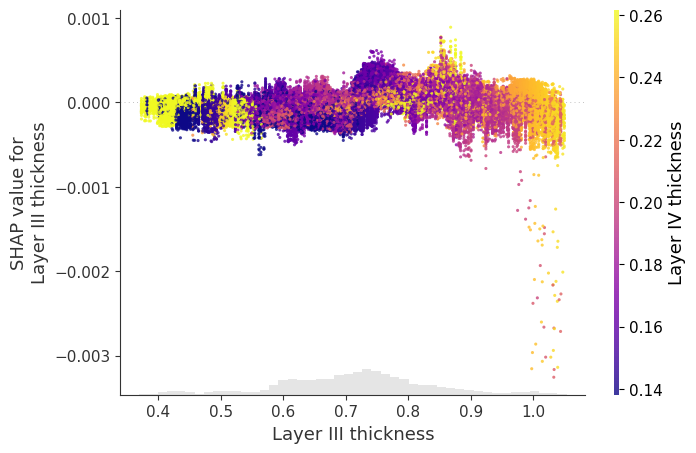

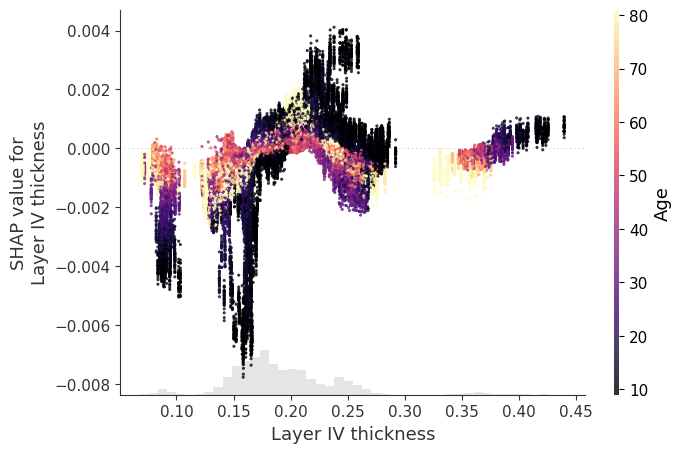

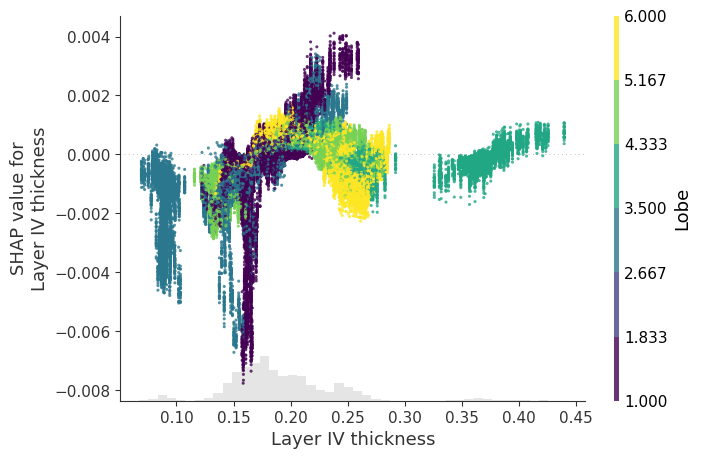

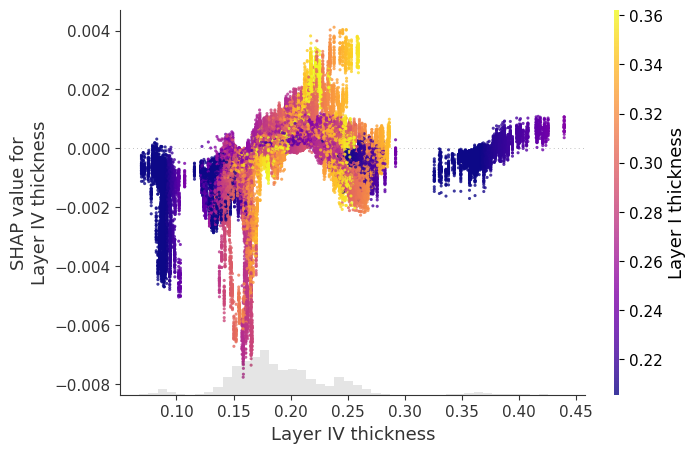

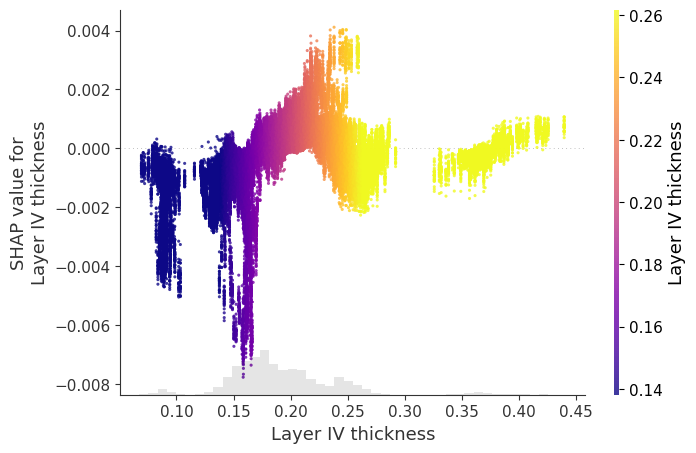

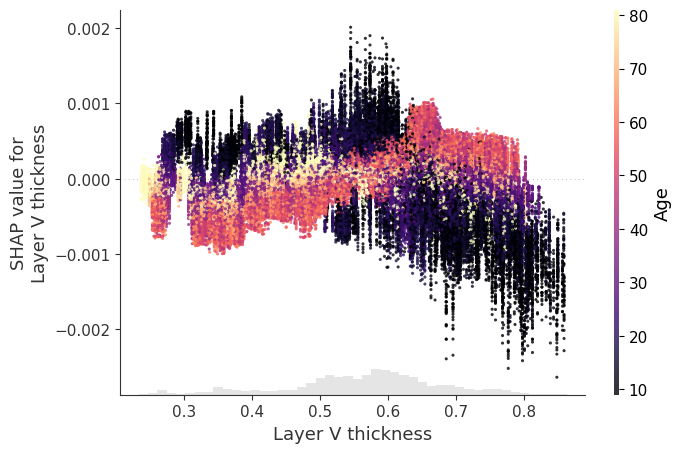

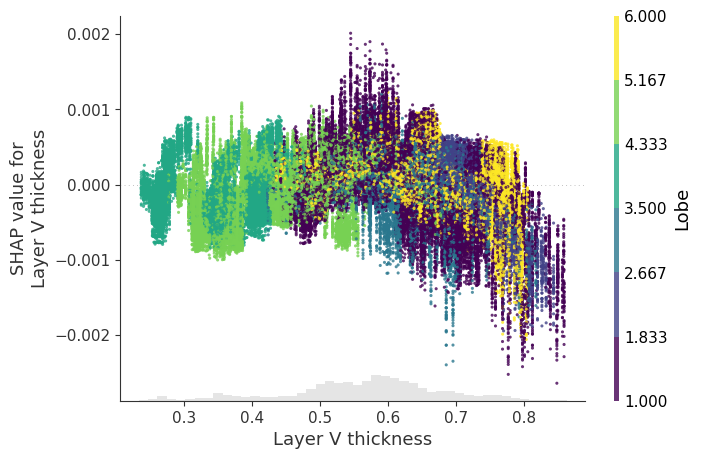

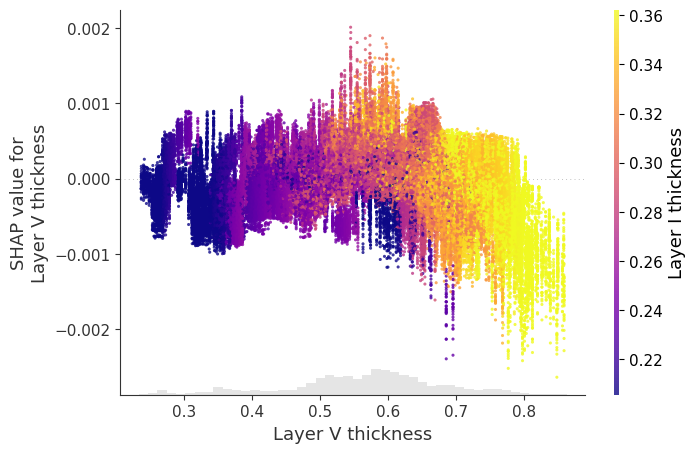

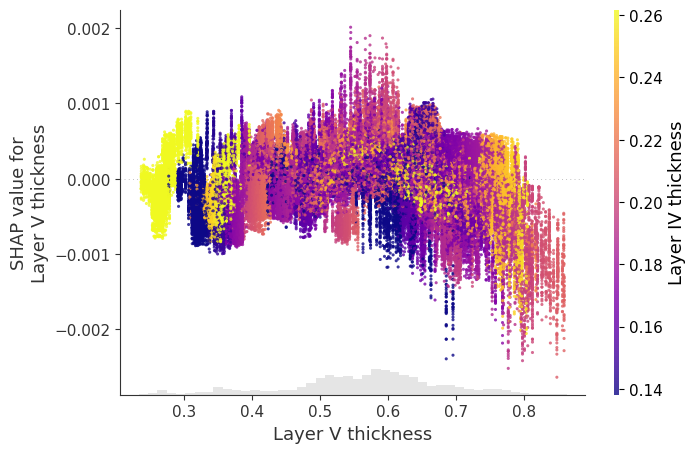

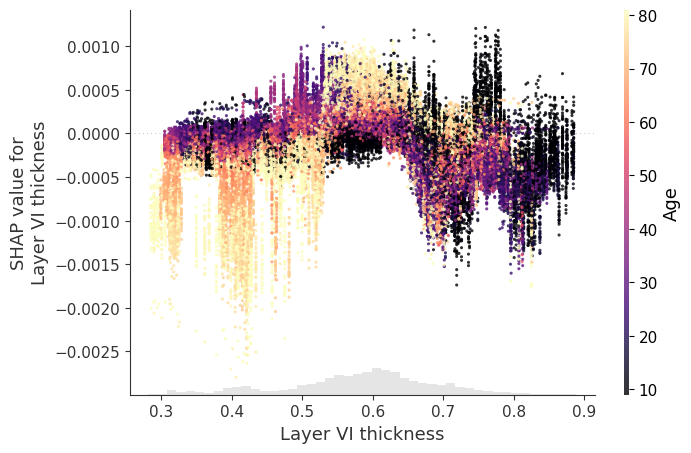

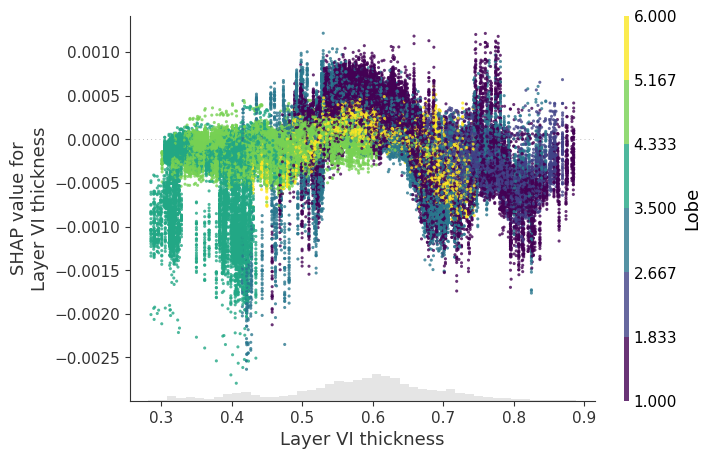

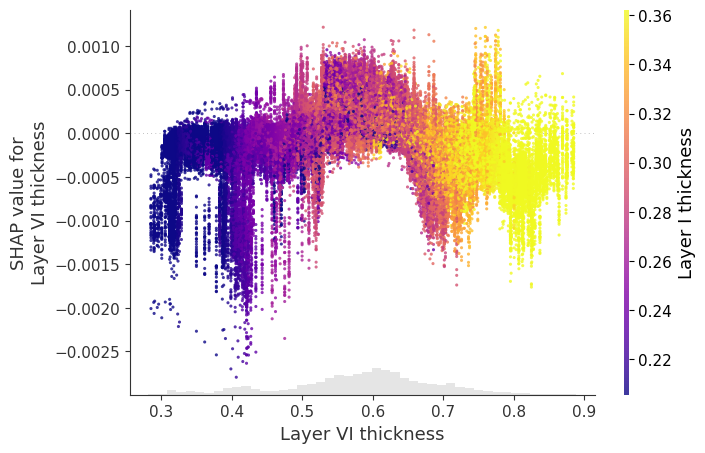

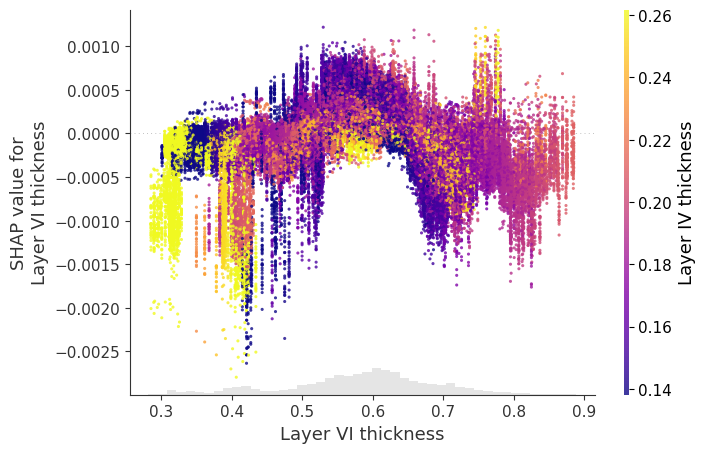

In [14]:
te.explicability_shap(X_train, lgbm, df_eval_1, features_sets, features_set=2)